# MRI Reconstruction: a comparison between classical and learning approaches

In this notebook we will compare 2 techniques for reconstructing MRI images:
- the classical, wavelet-based, iterative reconstruction.
- the cascade-net [1]

[1] Schlemper, J., Caballero, J., Hajnal, J. V, Price, A., & Rueckert, D. (2018). A Deep Cascade of Convolutional Neural Networks for MR Image Reconstruction. IEEE Transactions on Medical Imaging, 37(2), 491–503. https://doi.org/10.1109/TMI.2017.2760978

# A bit of context
MRI stands for Magnetic Resonance Imaging.
It is a medical imaging modality that is used to probe soft tissues inside the human body non-invasively and without the use of ionizing radiations.

However, MRI is particularly slow because it relies on the Magnetic Resonance phenomenon, which is inherently slow.
One way to speed up MRI is to acquire fewer signals (k-space shots ${\bf y}$), i.e. undersample.
If we do that, we find ourselves in a situation where we have not enough signals to reconstruct the image using simply the Inverse Fourier Transform ($F^{-1}$) as is typically done.
In fact, we have an ill-posed inverse problem that one must solve using priors on the MR images ${\bf x}$.

$$
F_{\Omega}{\bf x} = {\bf y}
$$


This means that we need a function to tell apart all the possible solutions of the inverse problem, that tells which solution is more likely to be an MR image.

In classical Compressed Sensing, these priors are handcrafted.
Deep Learning allows us to learn these priors from data.

In [1]:
!pip install --upgrade pip;

In [2]:
!pip install python-pysap pysap-mri;

     |████████████████████████████████| 656 kB 6.0 MB/s            
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 50 kB 7.8 MB/s             
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 25.9 MB 14.2 MB/s            
  Using cached matplotlib-3.3.4-cp37-cp37m-manylinux1_x86_64.whl (11.5 MB)
     |████████████████████████████████| 10.3 MB 8.5 MB/s            
     |████████████████████████████████| 824 kB 14.1 MB/s            
  Using cached progressbar2-3.53.1-py2.py3-none-any.whl (25 kB)
     |████████████████████████████████| 59 kB 10.9 MB/s            
  Using cached scikit_learn-0.24.1-cp37-cp37m-manylinux2010_x86_64.whl (22.3 MB)
  Using cached PyWavelets-1.1.1-cp37-cp37m-manylinux1_x86_64.whl (4.4 MB)
  Created wheel for python-pysap: filename=python_pySAP-0.0.5-cp37-cp37m-linux_x86_64.whl size=3426055 sha256=63fe83812fb606a3d95bc2dd9133c0c0169934beeb57c13e53ae387ed38b45ad
  Stored in directory: /home/zacchari

In [1]:
%matplotlib inline
from huggingface_hub import hf_hub_download
import matplotlib.pyplot as plt
from mri.operators import FFT, WaveletN
from mri.operators.utils import convert_mask_to_locations
from mri.reconstructors import SingleChannelReconstructor
from modopt.opt.proximity import SparseThreshold
from modopt.opt.linear import Identity
import numpy as np

from fastmri_recon.data.utils.crop import crop_center
from fastmri_recon.data.utils.masking.gen_mask import gen_mask
from fastmri_recon.evaluate.metrics.np_metrics import psnr, ssim
from fastmri_recon.models.functional_models.cascading import cascade_net

/home/zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.7/site-packages/mri/operators/fourier/non_cartesian.py:27: UserWarning: pynfft python package has not been found. If needed use the master release.
  warnings.warn("pynfft python package has not been found. If needed use "
/home/zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.7/site-packages/mri/operators/fourier/non_cartesian.py:35: UserWarning: gpuNUFFT python package has not been found. If needed please check on how to install in README
  warnings.warn("gpuNUFFT python package has not been found. If needed "
2021-12-20 17:31:46.001002: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-20 17:31:46.001021: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
/

In [14]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.rcParams['image.cmap'] = 'gray'
plt.style.use('ieee')
plt.rcParams['font.size'] = 6

In [3]:
np.random.seed(0)

# Data handling

The data comes from the fastMRI database [2]. We selected the 16th slice of the first validation file (`file1000000`).

[2] Zbontar, J., Knoll, F., Sriram, A., Muckley, M. J., Bruno, M., Defazio, A., … Lui, Y. W. (n.d.). fastMRI: An Open Dataset and Benchmarks for Accelerated MRI. Retrieved from https://arxiv.org/pdf/1811.08839.pdf

## Data loading

In [4]:
image = np.load('gt_image.npy')
kspace = np.load('gt_kspace.npy')

ipykernel_launcher:4: RuntimeWarning: divide by zero encountered in log
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


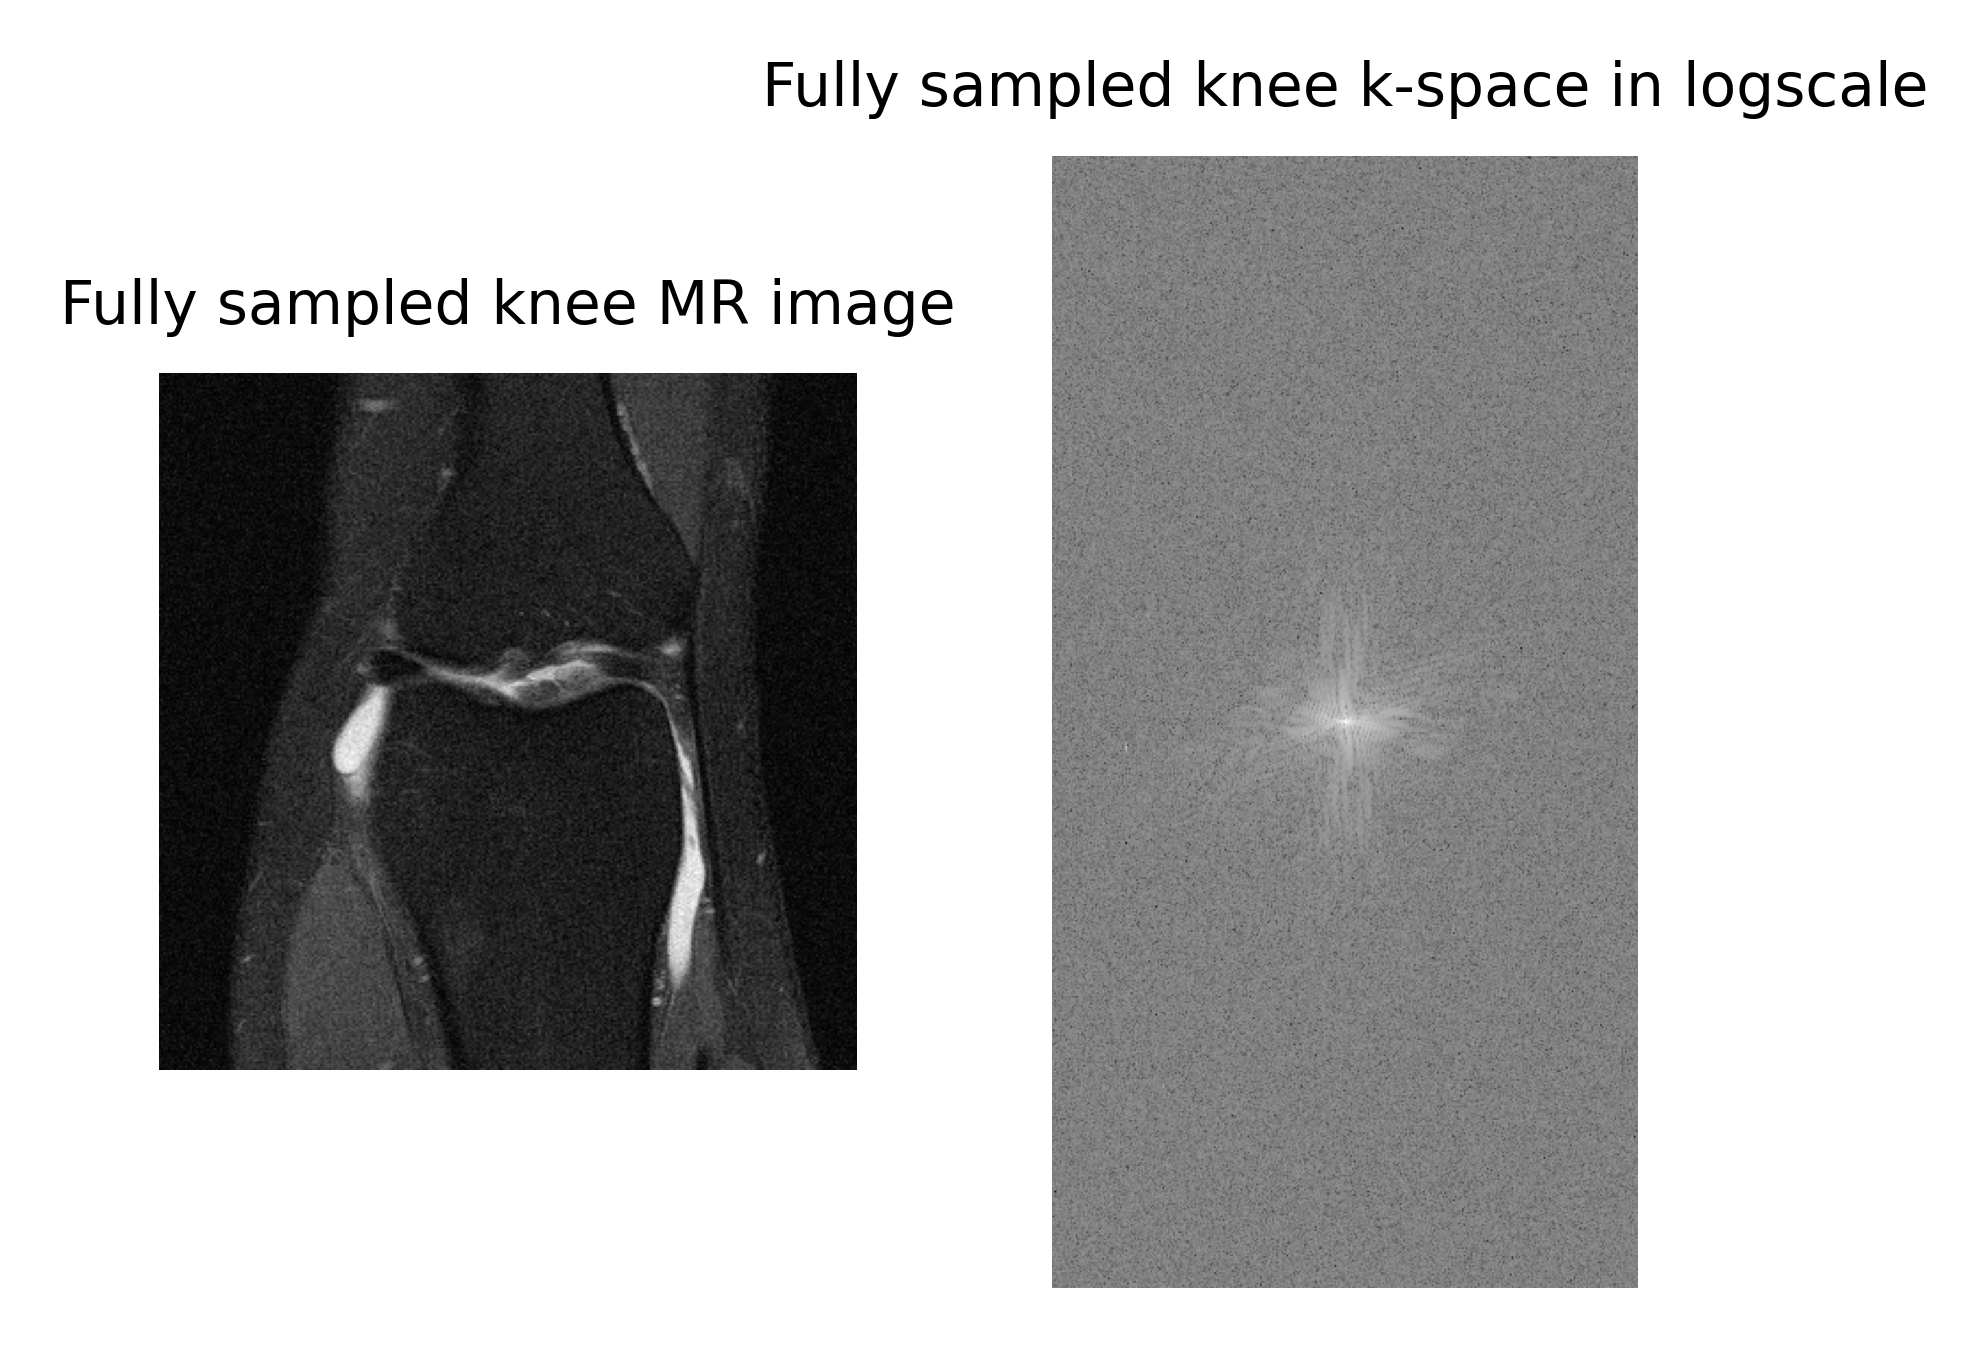

In [15]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(image[..., 0])
axs[0].set_title('Fully sampled knee MR image')
axs[1].imshow(np.log(np.abs(kspace[..., 0])))
axs[1].set_title('Fully sampled knee k-space in logscale')
for i in [0, 1]:
    axs[i].axis('off')

## Retrospective undersampling

In order to compare different reconstruction algorithms, i.e. algorithms that generate an MR image from undersampled data, we will simulate the acquisition of undersampled data via a retrospective undersampling.

In practice, this means that we multiply the original k-space by a binary mask in which the 1 entries correspond to the sampled points in the k-space and the 0 entries correspond to the non-sampled points.

In [16]:
AF = 4
mask = gen_mask(kspace[..., 0], accel_factor=AF, seed=0)
# the mas is received in fastmri format, we make a 1 and 0 mask in the fourier space
fourier_mask = np.repeat(mask.astype(np.float), kspace.shape[0], axis=0)
masked_kspace = fourier_mask[..., None] * kspace

Text(0.5, 1.0, 'Mask simulating the undersampling in the Fourier space')

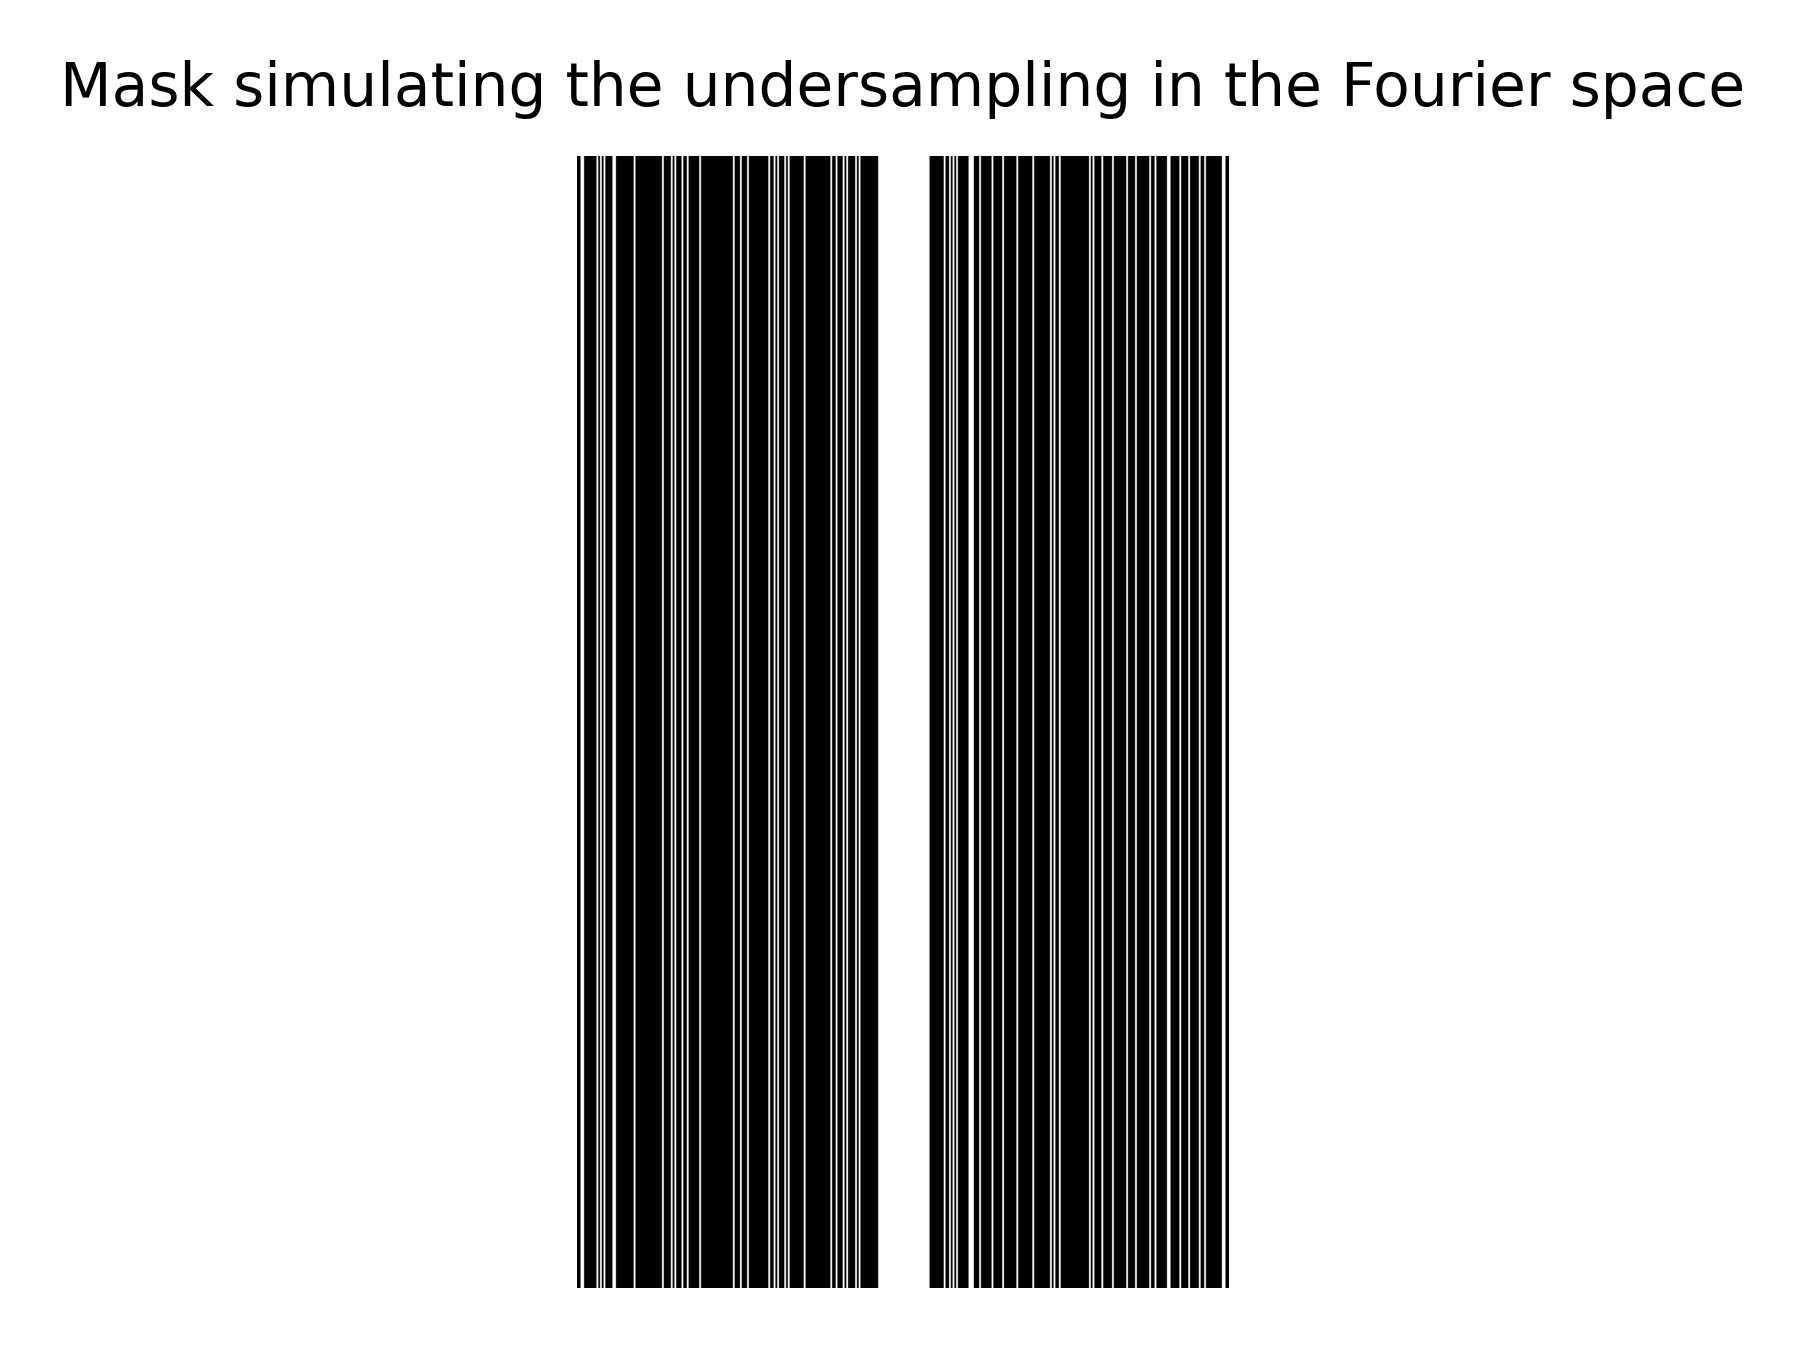

In [17]:
plt.figure()
plt.imshow(fourier_mask)
plt.axis('off')
plt.title('Mask simulating the undersampling in the Fourier space')

If one applies the Inverse Fourier Transform directly on the undersampled data, i.e. the masked out k-space, one obtains an aliased image.

Text(0.5, 1.0, 'Aliased MR image')

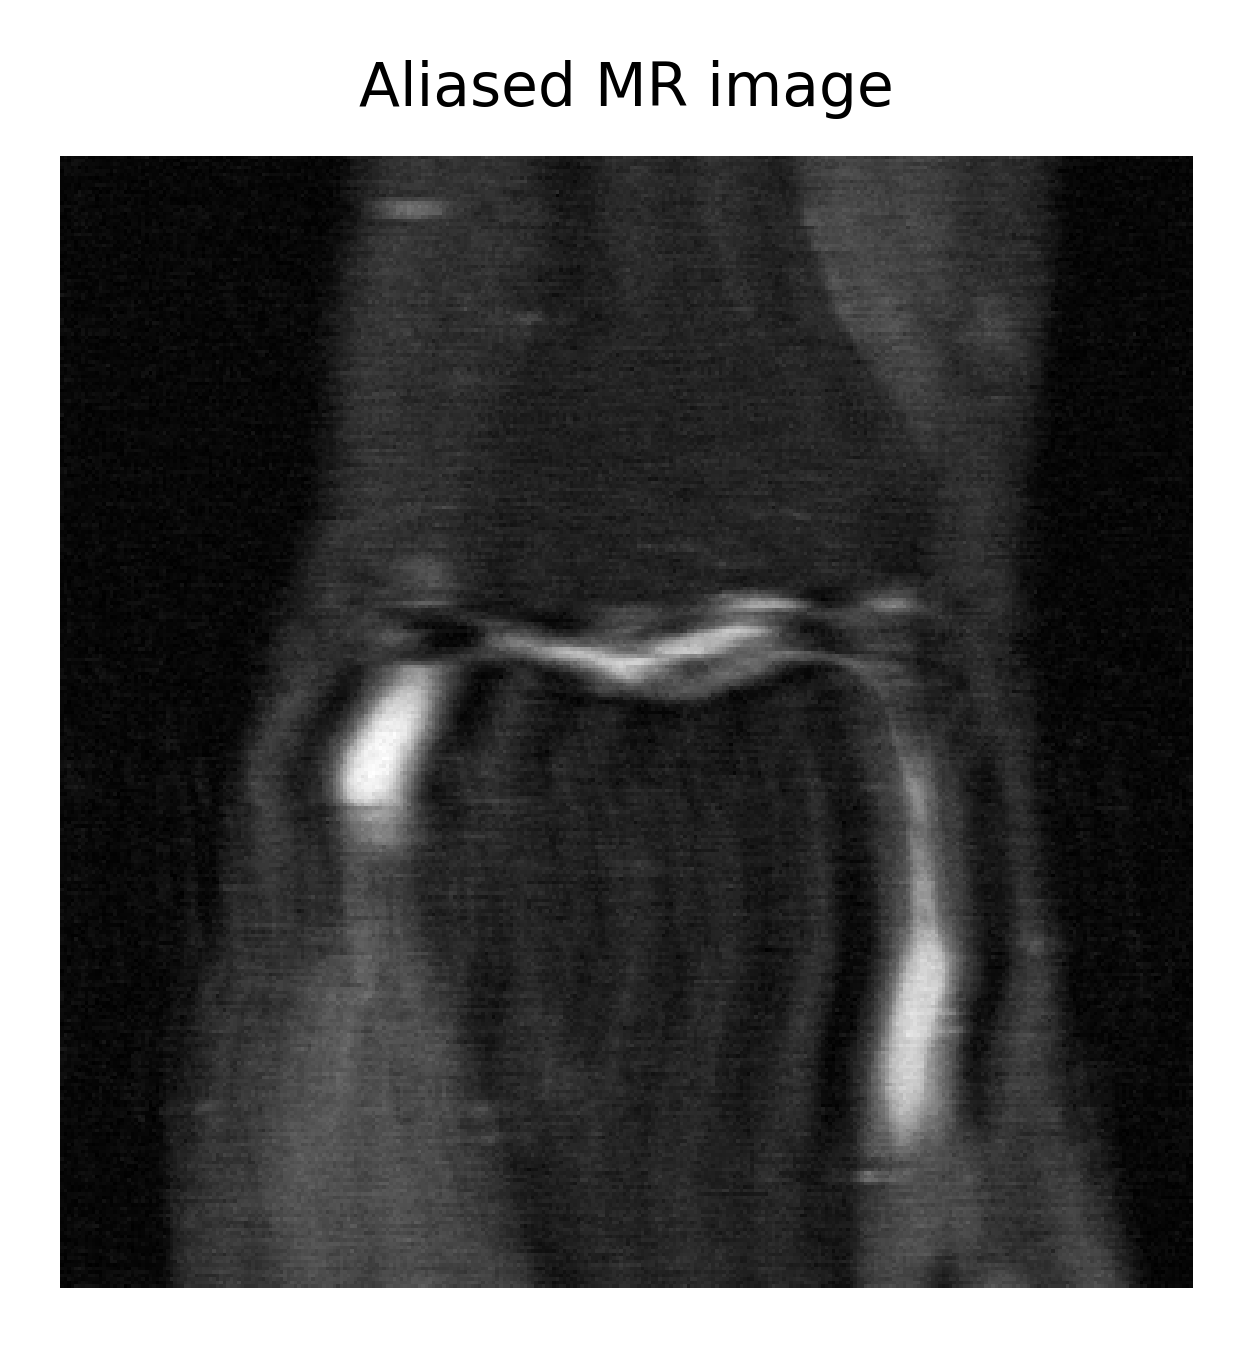

In [19]:
plt.figure()
plt.imshow(crop_center(np.abs(np.fft.fftshift(np.fft.ifft2(masked_kspace[..., 0], norm='ortho'))), 320))
plt.axis('off')
plt.title('Aliased MR image')

## Batching

Batching is necessary when using neural networks on both the training and the prediction steps.

In [20]:
mask_batch = fourier_mask[None, ...]
masked_kspace_batch = masked_kspace[None, ...]

## Scaling
Scaling was used for training to avoid numerical approximations that lead to poor training. Generally the inputs are normalized, but it was easier here to just scale them using the mean over the training set.

In [21]:
masked_kspace_batch *= 1e6

# Reconstruction using the Cascade net neural network

## Model loading

In [22]:
run_params = {
    'n_cascade': 5,
    'n_convs': 5,
    'n_filters': 48,
    'noiseless': True,
}
model_name = 'CascadeNet-fastmri'

In [23]:
model = cascade_net(input_size=(None, None, 1), fastmri=True, **run_params)
model_weights_path = hf_hub_download(
    repo_id=f'zaccharieramzi/{model_name}',
    filename='model_weights.h5',
)
model.load_weights(model_weights_path)

2021-12-20 17:40:48.604386: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-12-20 17:40:48.605361: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libnvidia-fatbinaryloader.so.418.39: cannot open shared object file: No such file or directory
2021-12-20 17:40:48.605375: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-20 17:40:48.605401: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (zaccharie-Latitude-7490): /proc/driver/nvidia/version does not exist
2021-12-20 17:40:48.606208: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
Downloading: 100%|██████████| 1.83M/1.83M [00:00<00:00, 3.49MB/s]


## Reconstruction

In [24]:
%%time
cascade_reconstructed_image = model.predict_on_batch([masked_kspace_batch, mask_batch])

2021-12-20 17:40:56.674051: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-12-20 17:40:56.697633: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2099940000 Hz


CPU times: user 10.7 s, sys: 431 ms, total: 11.1 s
Wall time: 5.33 s


## Visual comparison

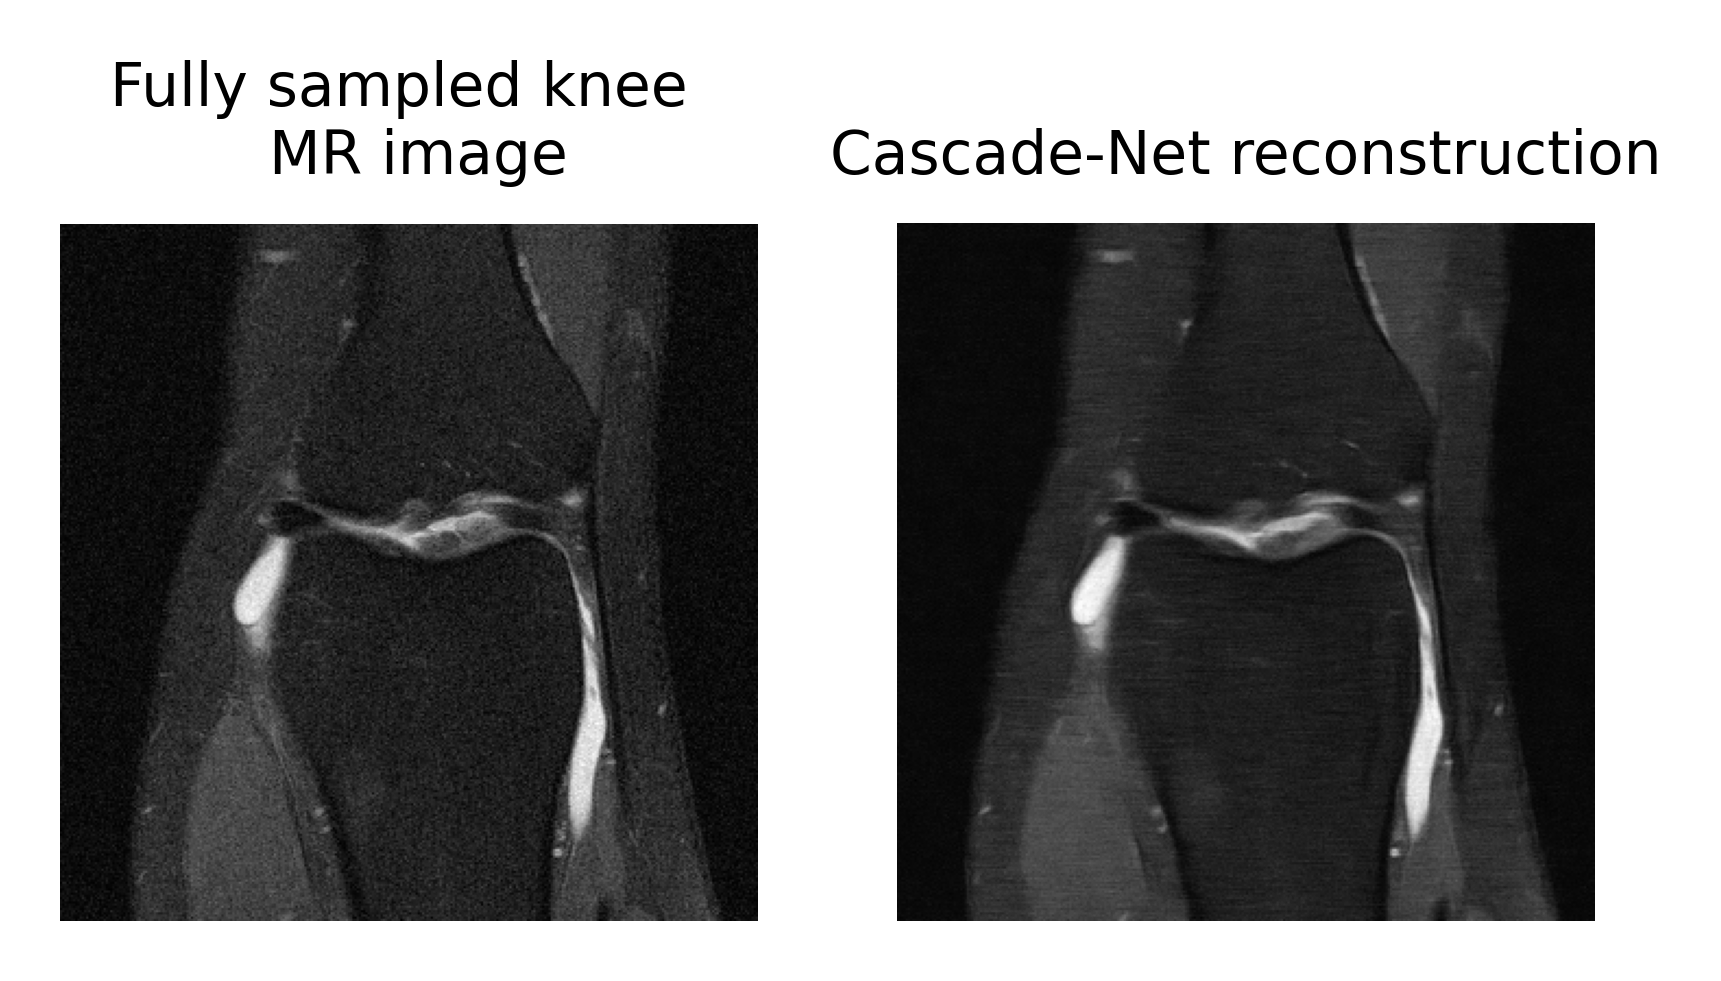

In [27]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].imshow(image[..., 0])
axs[0].set_title('Fully sampled knee \n MR image')
axs[1].imshow(cascade_reconstructed_image[0, ..., 0])
axs[1].set_title('Cascade-Net reconstruction')
for i in [0, 1]:
    axs[i].axis('off')

## Quantitative comparison

In [28]:
print('PSNR of the net reconstructed image:', psnr(image, cascade_reconstructed_image[0]/1e6))

PSNR of the net reconstructed image: 29.292248591114397


In [29]:
print('SSIM of the net reconstructed image:', ssim(image[None, ..., 0], cascade_reconstructed_image[..., 0]/1e6))

SSIM of the net reconstructed image: 0.6164851


/home/zaccharie/workspace/fastmri-reproducible-benchmark/fastmri_recon/evaluate/metrics/np_metrics.py:32: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0.Please use `channel_axis` instead.
  gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max() - gt.min()


# Reconstruction using pysap

## Reformatting the data

In [30]:
kspace_squeeze = np.squeeze(kspace*1e6)
k_shape = kspace_squeeze.shape
kspace_loc = convert_mask_to_locations(fourier_mask)

## Creating the appropriate operators

In [31]:
fourier_op = FFT(samples=kspace_loc, shape=k_shape)

/home/zaccharie/workspace/fastmri-reproducible-benchmark/venv/lib/python3.7/site-packages/mri/operators/fourier/utils/processing.py:76: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  mask[test] = 1


In [57]:
linear_op = WaveletN(wavelet_name="sym8", nb_scales=4, padding_mode="periodization")
regularizer_op = SparseThreshold(Identity(), 0.1, thresh_type="soft")
# Setup Reconstructor
reconstructor = SingleChannelReconstructor(
    fourier_op=fourier_op,
    linear_op=linear_op,
    regularizer_op=regularizer_op,
    gradient_formulation='synthesis',
    verbose=1,
)

Lipschitz constant is 1.1000000000001653
The lipschitz constraint is satisfied


## Reconstruction
For the reconstruction we will use the FISTA algorithm

In [58]:
x_final, costs, metrics = reconstructor.reconstruct(
    kspace_data=kspace_squeeze,
    optimization_alg='fista',
    num_iterations=200,
)
image_rec_fs = crop_center(np.abs(x_final), 320)

 - mu:  0.1
 - lipschitz constant:  1.1000000000001653
 - data:  (640, 368)
 - wavelet:  <mri.operators.linear.wavelet.WaveletN object at 0x7ff1e3bef350> - 4
 - max iterations:  200
 - image variable shape:  (640, 368)
 - alpha variable shape:  (235520,)
----------------------------------------
Starting optimization...


100% (200 of 200) |######################| Elapsed Time: 0:00:14 Time:  0:00:14


 - final iteration number:  200
 - final log10 cost value:  6.0
 - converged:  False
Done.
Execution time:  14.774283039000238  seconds
----------------------------------------


## Visual comparison

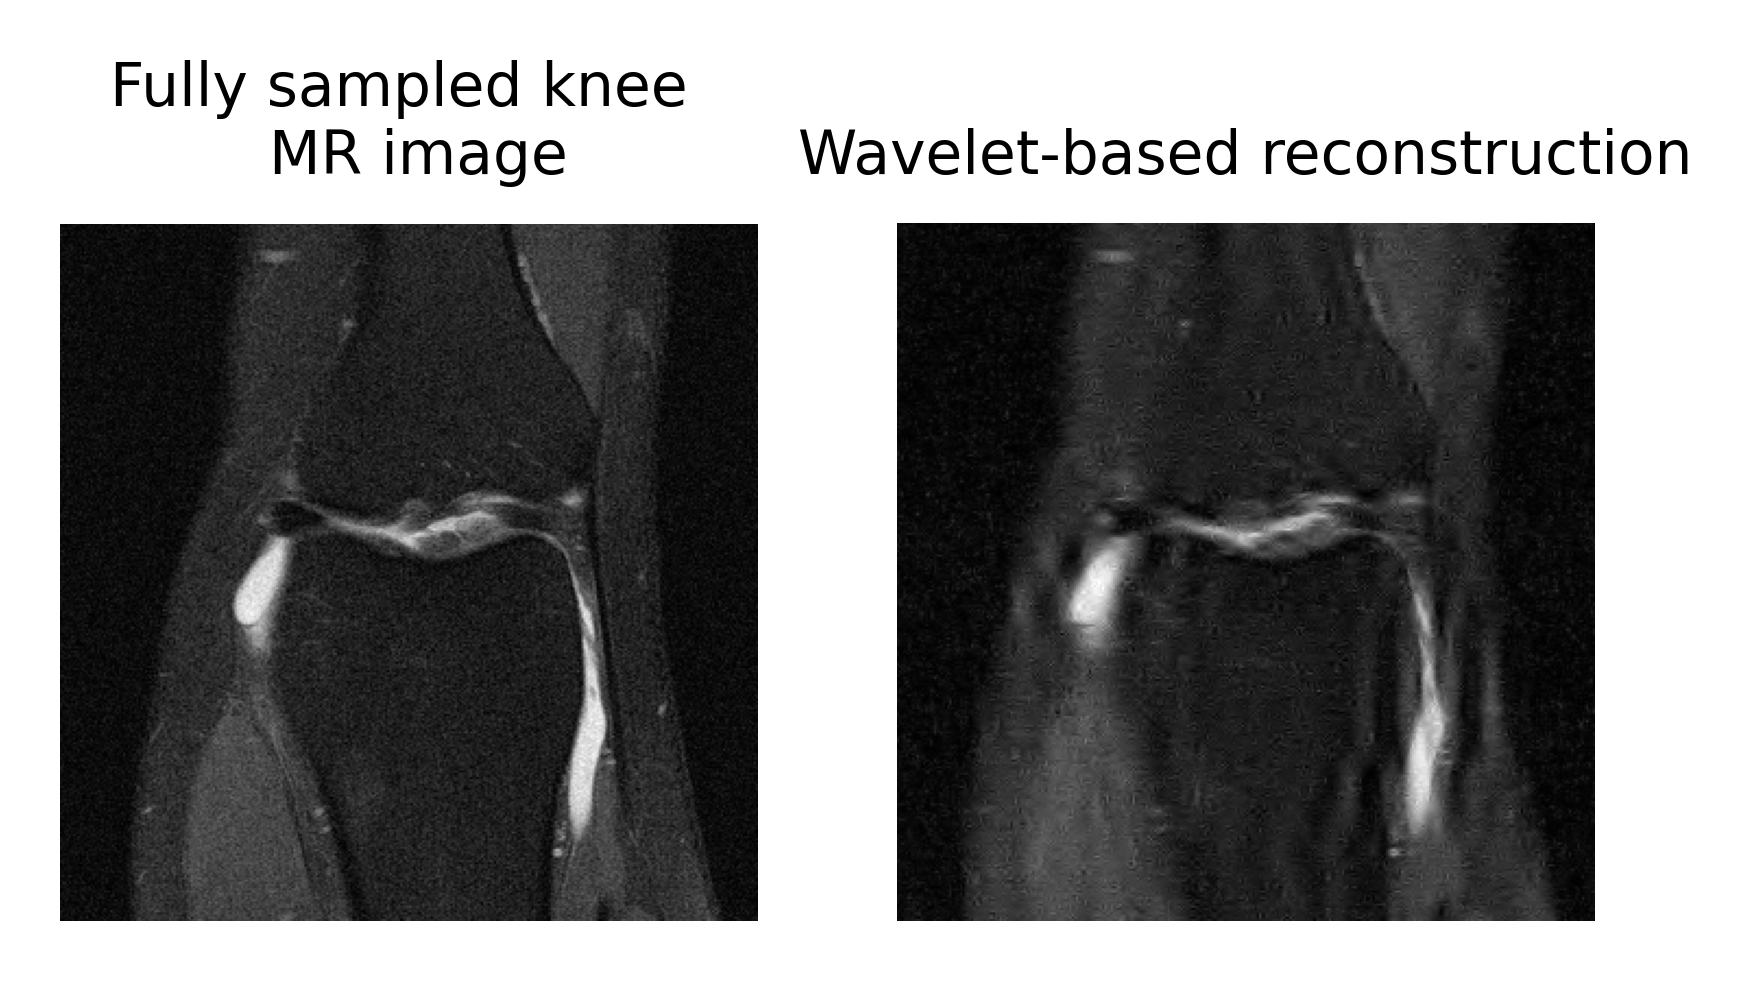

In [59]:
fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
axs[0].imshow(image[..., 0])
axs[0].set_title('Fully sampled knee \n MR image')
axs[1].imshow(image_rec_fs)
axs[1].set_title('Wavelet-based reconstruction')
for i in [0, 1]:
    axs[i].axis('off')

## Quantitative comparison

In [52]:
print('PSNR of the pysap reconstructed image:', psnr(image[..., 0], image_rec_fs/1e6))

PSNR of the pysap reconstructed image: 25.912591150634515


In [53]:
print('SSIM of the pysap reconstructed image:', ssim(image[None, ..., 0], image_rec_fs[None, ...]/1e6))

SSIM of the pysap reconstructed image: 0.49033758
